## Import Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data
This dataset consist of 188 image and their corresponding sketches.Data Augmentation is done using open cv library. After Augmentation around 1500 images are obtained. These images are converted into array and are stored in the list.

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/content/drive/MyDrive/Machine Learning/SDP/Image to Sketch/CUHK Face Sketch Database (CUFS)/sketches'
img_array = []

sketch_path = '/content/drive/MyDrive/Machine Learning/SDP/Image to Sketch/CUHK Face Sketch Database (CUFS)/photos'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))    

100%|██████████| 188/188 [01:45<00:00,  1.78it/s]


In [ ]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


# Visualizing images


In [ ]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Sketches', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Image', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

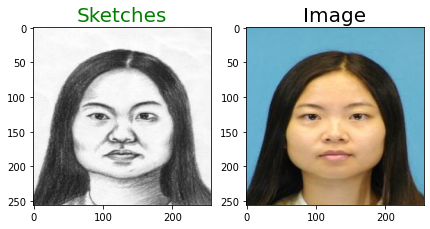

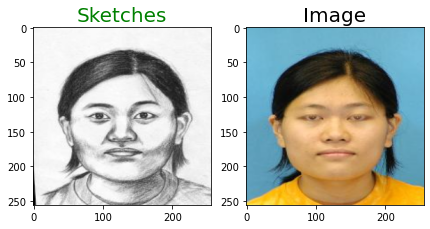

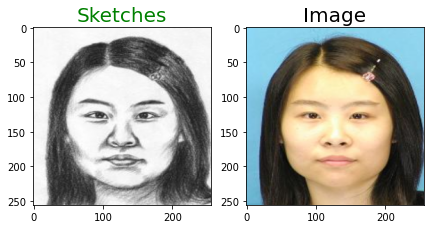

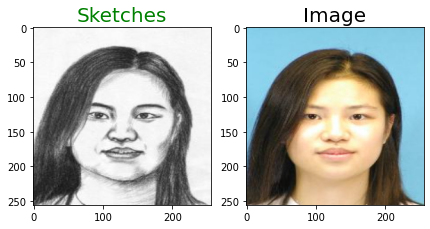

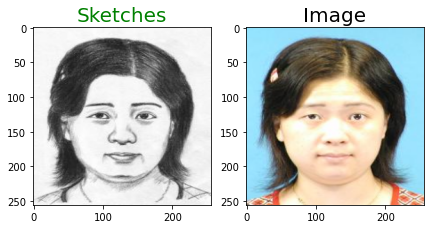

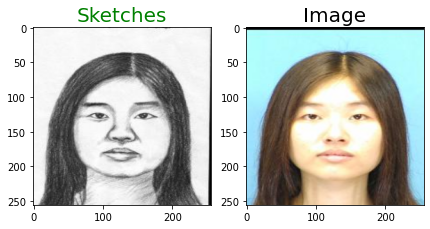

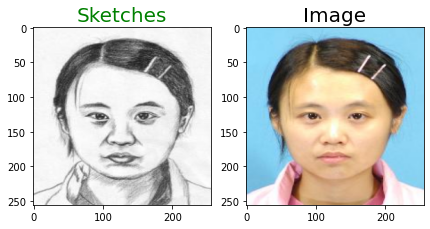

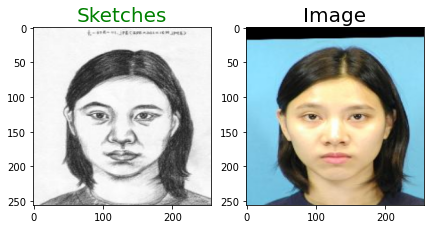

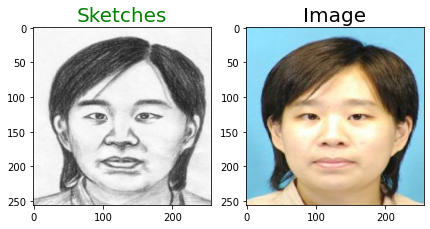

In [ ]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])



## Slicing and reshaping

Out of 1504 images I have sliced them to two part. train images consist 1400 images while test images contains 104 images. After slicing image array, I reshaped them so that images can be fed directly into our encoder network


In [ ]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


## Downsample layer

In [ ]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

## Upsample Layer

In [ ]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

# Model 
Here i have use sequence of downsample layer for encoder and upsample layer for decoder

In [ ]:
## Model
# Here I have defined two blocks of networks. Encoder network takes 256 by 256 image and downsample it to 16 by 16 latent vector
# by passing our image via series of Convolution and Maxpooling layer. This downsampled 16 by 16 latent vector is upsampled by passing 
# through series of Convolution and UpSampling layer. The final decoder output is same as our encoder input. This upsamples output of decoder
# is compared with our sketches and reconstruction loss is calculated. This loss is minimized by updating weight and bias of network through
# backpropagation.
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)

decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
 
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

# final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                       

### Compiling and Fitting our model

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # checkpoint = ModelCheckpoint("/content/model/", monitor='val_acc')

# early_stopping = EarlyStopping(monitor='val_acc', patience=5)

# callbacks_list = [early_stopping]

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_image, train_sketch_image, epochs = 100)
# history=model.fit(train_image, train_sketch_image, epochs = 100)

Epoch 1/100
44/44 [==============================] - 35s 461ms/step - loss: 0.3446 - acc: 0.1117
Epoch 2/100
44/44 [==============================] - 16s 364ms/step - loss: 0.1818 - acc: 0.2026
Epoch 3/100
44/44 [==============================] - 16s 366ms/step - loss: 0.1361 - acc: 0.7164
Epoch 4/100
44/44 [==============================] - 16s 362ms/step - loss: 0.1196 - acc: 0.7948
Epoch 5/100
44/44 [==============================] - 16s 364ms/step - loss: 0.1095 - acc: 0.8383
Epoch 6/100
44/44 [==============================] - 16s 365ms/step - loss: 0.1038 - acc: 0.8728
Epoch 7/100
44/44 [==============================] - 16s 365ms/step - loss: 0.1016 - acc: 0.8775
Epoch 8/100
44/44 [==============================] - 16s 365ms/step - loss: 0.1035 - acc: 0.8718
Epoch 9/100
44/44 [==============================] - 16s 365ms/step - loss: 0.0996 - acc: 0.8827
Epoch 10/100
44/44 [==============================] - 16s 366ms/step - loss: 0.0982 - acc: 0.8888
Epoch 11/100
44/44 [=========

In [ ]:
# Loss Curve
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# Accuracy Curve
# plt.plot(history.history['acc'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# model.save("model.h5")

In [ ]:
# model = tf.keras.models.load_model("/content/drive/MyDrive/Machine Learning/SDP/Image to Sketch/model.h5")

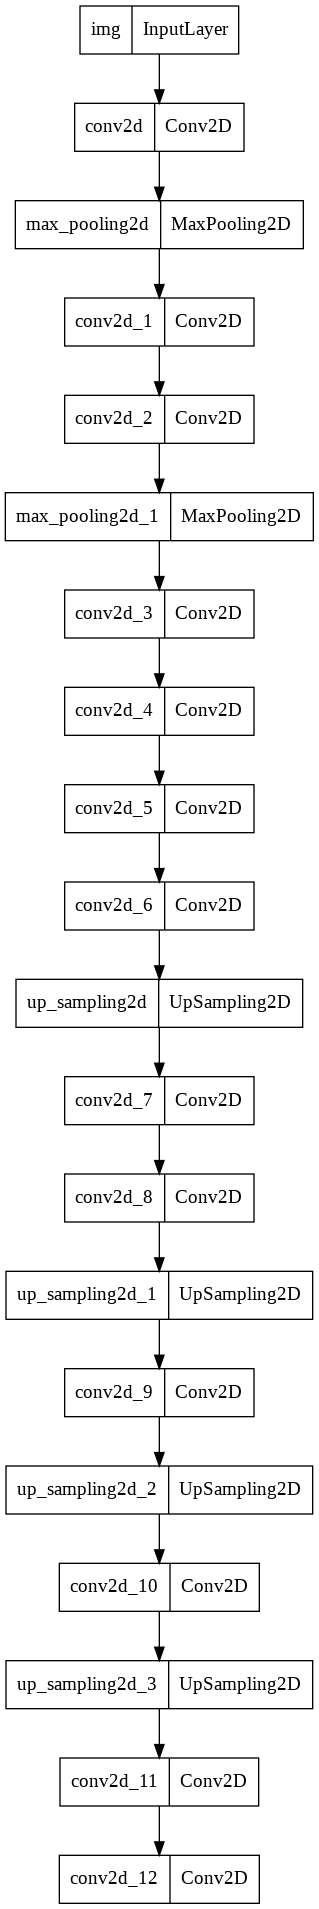

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

### Evaluating our model

In [ ]:
prediction_on_train_data = model.evaluate(train_image, train_sketch_image)
print("Loss: ", prediction_on_train_data[0])
print("Accuracy: ", np.round(prediction_on_train_data[1] * 100,1))

prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

44/44 [==============================] - 7s 148ms/step - loss: 0.0344 - acc: 0.9343
Loss:  0.03436370939016342
Accuracy:  93.4
4/4 [==============================] - 2s 524ms/step - loss: 0.0750 - acc: 0.9299
Loss:  0.07502217590808868
Accuracy:  93.0


# Plotting our predicted sketch along with real sketch

In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Sketch",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("Coloured Image",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted Image",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

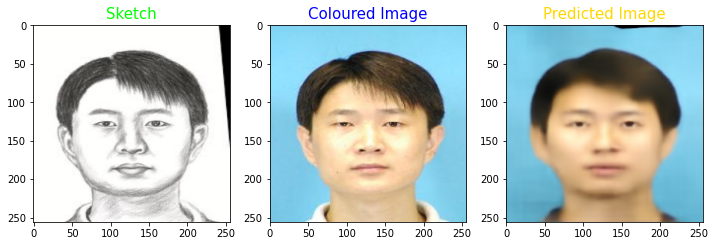

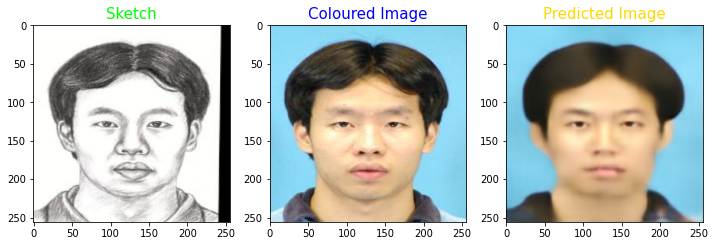

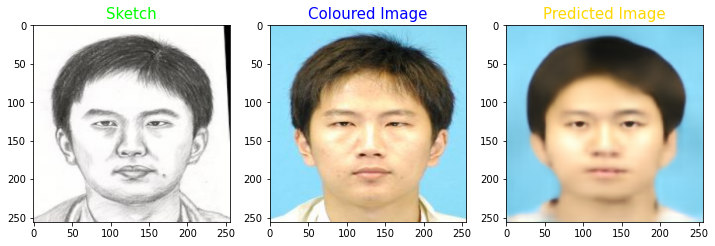

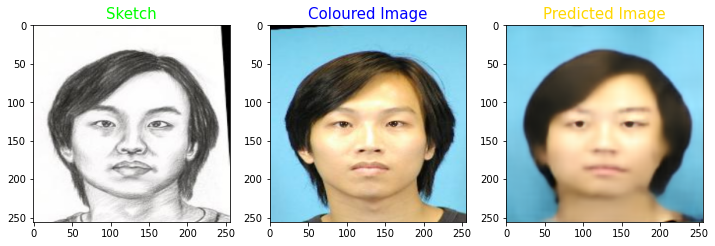

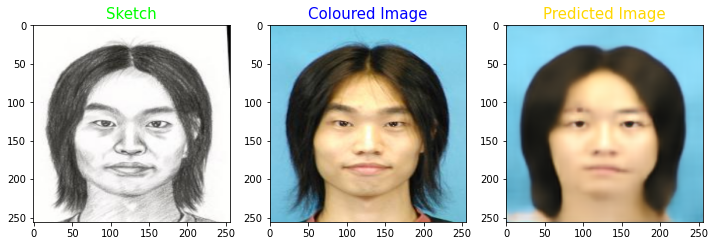

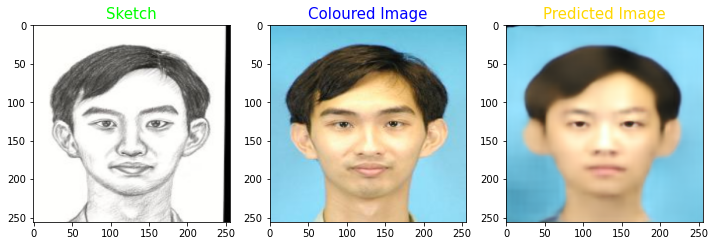

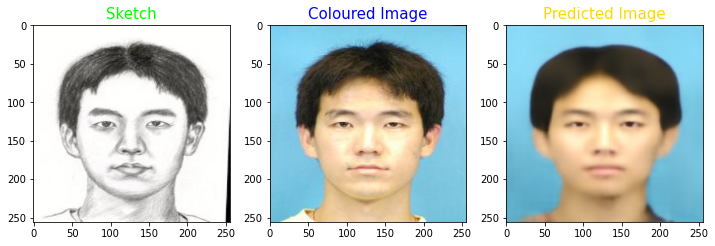

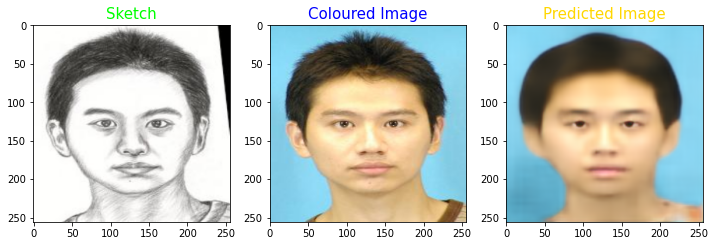

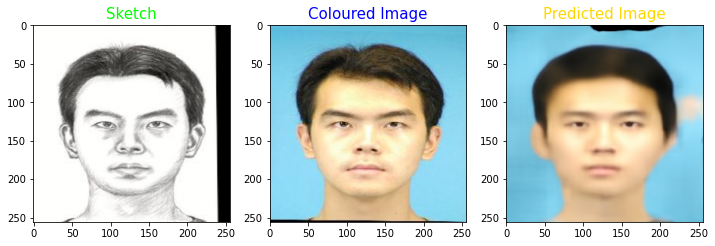

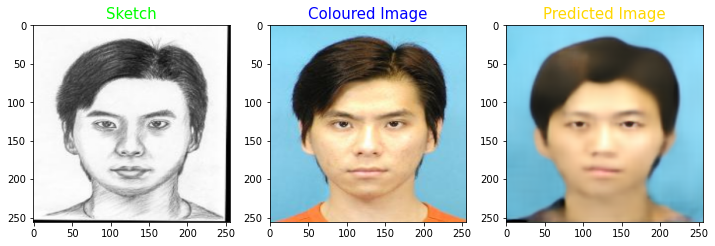

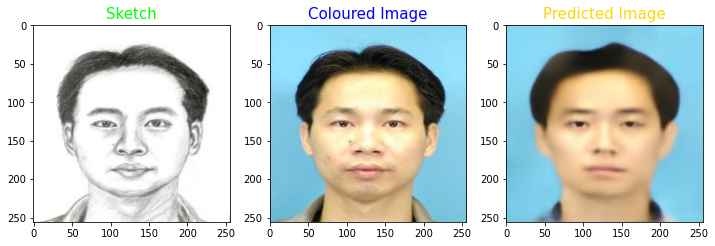

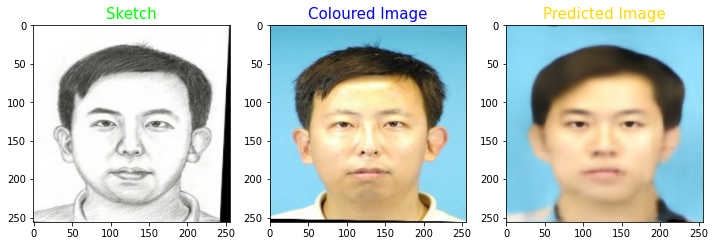

In [ ]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)